In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from datetime import datetime
import cvxpy as cvx


In [2]:
import sys
print('{0[0]}.{0[1]}'.format(sys.version_info))

3.6


In [3]:
data_folder = os.path.join(os.path.dirname(os.getcwd()), 'data')
data_file = os.path.join(data_folder, 'data_train')
data = pd.read_csv(data_file)

In [4]:
# Extract prices and dates.

sequrity_ids = data.columns[1:]
dates = [datetime.strptime(d, '%Y-%m-%d') for d in data['Date']]
prices = np.array(data[sequrity_ids]).T
cov = np.corrcoef(prices)
N = len(sequrity_ids)
T = len(dates)

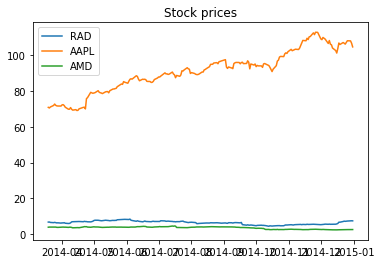

In [5]:
# Visualize some prices.

seq_to_show = ['RAD', 'AAPL', 'AMD']

for seq in seq_to_show:
    plt.plot(dates[-200:], data[seq][-200:], label = seq)
plt.legend()
plt.title("Stock prices")
plt.show()

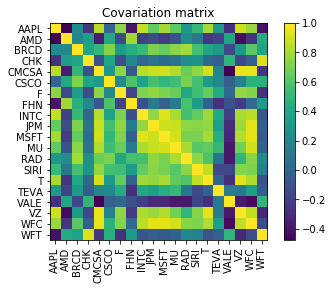

In [6]:
# Visualize covariation matrix.

plt.imshow(cov, interpolation='none')
plt.colorbar()
plt.xticks(range(len(sequrity_ids)), sequrity_ids, fontsize=10,rotation='vertical')
plt.yticks(range(len(sequrity_ids)), sequrity_ids, fontsize=10,rotation='horizontal')
plt.title("Covariation matrix")
plt.show()

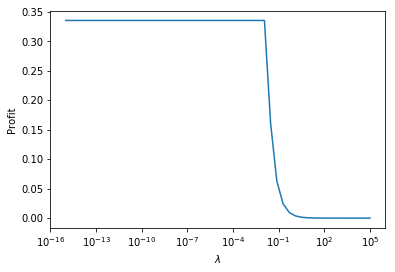

Optimal lambda is 2.023590e-10
Optimal profit is 0.335702


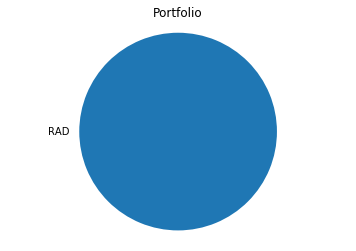

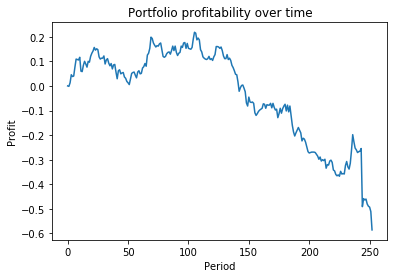

Profit on test data in 30 steps: 12.181818%


In [8]:
# This function should return prediction for given time series, in moment of time
# which is T times time series step.
def predict_stupid(ts, dates, T):
    dp = ts[-1]-ts[-2]
    return ts[-1] + T*dp

def predict_very_stupid(ts, dates, T):
    return ts[-1]

# Calculates profit if we buy sequrities at time_buy, sell them
# at time_sell, spend x[i] part of capital on i-rh security.
# Assumes that initial capital is equal to 1.
def count_profit(prices, date_buy, date_sell, x):    
    prices_at_buy = prices[:, date_buy]
    prices_at_sell = prices[:, date_sell]
    capital_spent = np.sum(x)
    amount_bought = x / prices_at_buy
    revenue = np.dot(amount_bought, prices_at_sell)
    return revenue - np.sum(x)

# Calculates real profit on test data.
test_prices = None
def count_real_profit(portfolio, period):
    global test_prices 
    if test_prices is None:
        data_folder = os.path.join(os.path.dirname(os.getcwd()), 'data')
        data_test_file = os.path.join(data_folder, 'data_test')
        data = pd.read_csv(data_file)
        test_prices = np.array(data[sequrity_ids]).T
    return count_profit(test_prices, 0, period, portfolio)

# By given profitabilities, cov.matrix and lambda gives optimal portfolio.
def get_optimal_portfolio(r, cov, l):
    x = cvx.Variable(N)
    
    objective = cvx.Maximize(r*x - l*cvx.quad_form(x, cov))
    constraints = [cvx.sum_entries(x) <= 1, x >= 0]
    prob = cvx.Problem(objective, constraints)
    obj = prob.solve()
    portfolio = np.copy(np.array(x.value).reshape(-1))
    return portfolio

def get_portfoilio_for_date(prices, date_buy, l, predict_function=predict_stupid):
    # Calculating profitabilities.
    period = date_sell - date_buy 
    r = np.array([
        (predict_function(prices[i, :date_buy+1], dates[:date_buy+1], 1) - prices[i, date_buy]) / prices[i, date_buy] for i in range(N)])
    cov = np.corrcoef(prices[:,:date_buy+1])
    return get_optimal_portfolio(r, cov, l)

def portfolio_info(portfolio, period=30):
    inv_seq = []
    for i in range(N):
        if portfolio[i] > 1e-7:
            inv_seq.append((opt_portfolio[i], sequrity_ids[i]))
    inv_seq.sort(reverse=True)
    non_zero_inv = len(inv_seq)
    fracs = [inv_seq[i][0] for i in range(non_zero_inv)]
    labels = [inv_seq[i][1] for i in range(non_zero_inv)]

    plt.pie(fracs, labels=labels)
    plt.axis('equal')
    plt.title('Portfolio')
    plt.show()

    period_range = range(253)
    profits = [count_real_profit(portfolio, period) for period in period_range]
    plt.plot(period_range, profits)
    plt.xlabel("Period")
    plt.ylabel("Profit")
    plt.title('Portfolio profitability over time')
    plt.show()
    
    print("Profit on test data in %d steps: %f%%" % (period, count_real_profit(portfolio, period)*100))
    
    
date_buy = T-30
date_sell = T-1
l_range = np.power(10, np.linspace(-15,5,50))
profit = np.zeros(len(l_range))
portfolios = np.zeros((len(l_range), N))

for i in range(len(l_range)):
    # Change here predict_stupid on name of your prediction function.
    portfolios[i] = get_portfoilio_for_date(prices, date_buy, l_range[i], predict_function=predict_stupid)
    profit[i] = count_profit(prices, date_buy, date_sell, portfolios[i])
    
plt.plot(l_range, profit)
plt.xscale("log", nonposx='clip')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'Profit')
plt.show()

                                            
print("Optimal lambda is %e" % l_range[np.argmax(profit)])
print("Optimal profit is %f" % np.max(profit))

opt_portfolio = portfolios[np.argmax(profit)]

portfolio_info(opt_portfolio)